In [1]:
import sys, torch
print(sys.executable)
print(torch.backends.mps.is_available())

/Users/home/Developer/github/makemore-notes/.venv/bin/python
True


# 01 — Bigrams (count-based model)

Goal: build a character-level bigram language model from scratch:
- build the vocabulary
- count bigram occurrences
- convert counts → probabilities
- sample new names
- compute average negative log-likelihood (NLL)

In [3]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path

torch.manual_seed(1337)

In [7]:
REPO_ROOT = Path.cwd()
# If you ever launch the notebook from inside /notebooks, this will still find the repo root:
if (REPO_ROOT / "data").exists() is False and (REPO_ROOT.parent / "data").exists():
    REPO_ROOT = REPO_ROOT.parent

data_path = REPO_ROOT / "data" / "names.txt"
print("Repo root:", REPO_ROOT)
print("Data path:", data_path)
print("Exists:", data_path.exists())

words = data_path.read_text().splitlines()
len(words), words[:10]

Repo root: /Users/home/Developer/github/makemore-notes
Data path: /Users/home/Developer/github/makemore-notes/data/names.txt
Exists: True


(32033,
 ['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'])

In [8]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(stoi)
vocab_size, chars[:10], stoi["."]

(27, ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'], 0)

In [9]:
N = torch.zeros((vocab_size, vocab_size), dtype=torch.int32)

for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        i = stoi[ch1]
        j = stoi[ch2]
        N[i, j] += 1

N.shape, N.sum()

(torch.Size([27, 27]), tensor(228146))

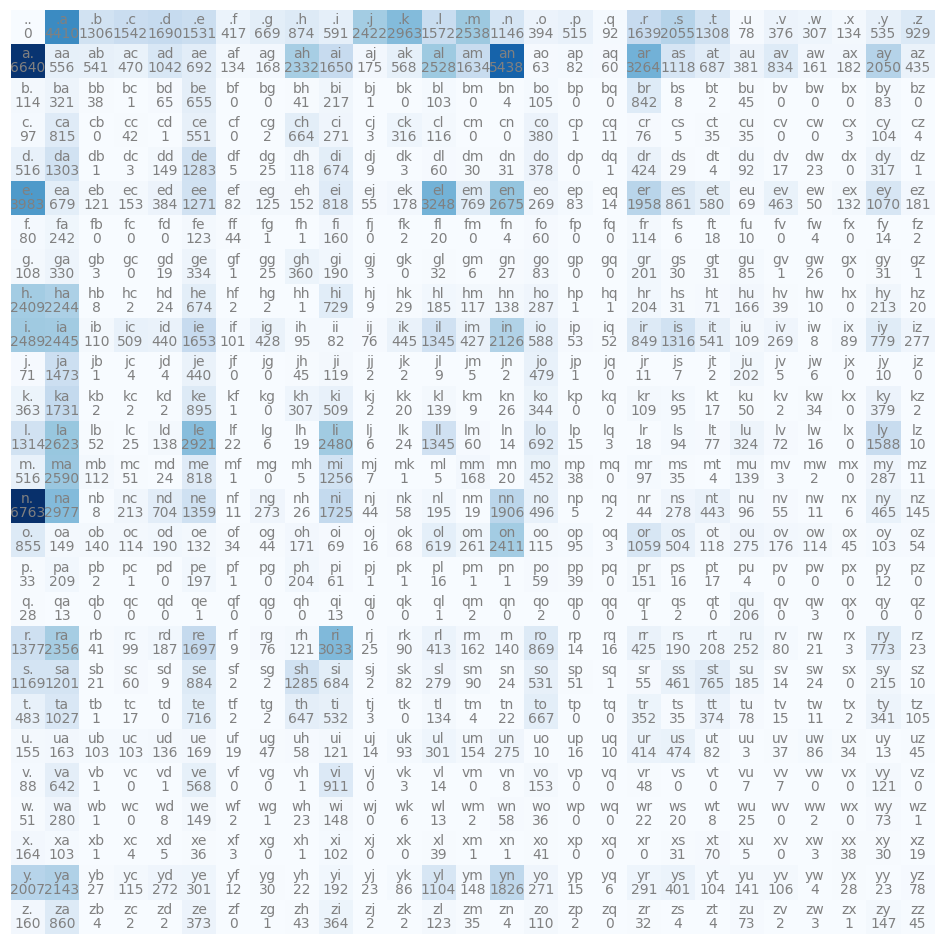

In [10]:
plt.figure(figsize=(12, 12))
plt.imshow(N, cmap="Blues")
plt.axis("off")

for i in range(vocab_size):
    for j in range(vocab_size):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, int(N[i, j]), ha="center", va="top", color="gray")
plt.show()

In [11]:
P = (N + 1).float()
P /= P.sum(dim=1, keepdim=True)

P[0].sum(), P.shape

(tensor(1.), torch.Size([27, 27]))

In [12]:
g = torch.Generator().manual_seed(2147483647)

def sample_name(P, stoi, itos, g, max_len=30):
    out = []
    ix = 0  # start token "."
    for _ in range(max_len):
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        out.append(itos[ix])
    return "".join(out)

for _ in range(10):
    print(sample_name(P, stoi, itos, g))

cexze
momasurailezitynn
konimittain
llayn
ka
da
staiyaubrtthrigotai
moliellavo
ke
teda


In [13]:
log_likelihood = 0.0
n = 0

for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        i = stoi[ch1]
        j = stoi[ch2]
        prob = P[i, j]
        log_likelihood += torch.log(prob)
        n += 1

nll = -log_likelihood / n
nll

tensor(2.4544)

In [14]:
assert N.shape[0] == vocab_size and N.shape[1] == vocab_size
assert torch.allclose(P.sum(dim=1), torch.ones(vocab_size), atol=1e-5)
assert isinstance(sample_name(P, stoi, itos, g), str)